Importing libraries

In [1268]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
import seaborn as sns;

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE


Data Loading and exploration

In [1269]:
# Importing day.csv
day = pd.read_csv('day.csv')

Data information 

In [1270]:
#Data summary , info , summary , describe
print("Shape",day.shape)
print("Description of data",day.describe())
print("Info of data",day.info())
# 16 columns with only dteday as object type everything else as float / int.
# no null columns

Shape (730, 16)
Description of data           instant      season          yr        mnth     holiday     weekday  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean   365.500000    2.498630    0.500000    6.526027    0.028767    2.997260   
std    210.877136    1.110184    0.500343    3.450215    0.167266    2.006161   
min      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
25%    183.250000    2.000000    0.000000    4.000000    0.000000    1.000000   
50%    365.500000    3.000000    0.500000    7.000000    0.000000    3.000000   
75%    547.750000    3.000000    1.000000   10.000000    0.000000    5.000000   
max    730.000000    4.000000    1.000000   12.000000    1.000000    6.000000   

       workingday  weathersit        temp       atemp         hum   windspeed  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean     0.683562    1.394521   20.319259   23.726322   62.765175   12.7

Data Cleaning
- Removal of null values
- Remove unnecessary column

In [1271]:
#Missing Values
print(day.isnull().sum())
#No missing values

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [1272]:
#Instant is a index value / unique value. we can drop it.
day.drop(['instant'],axis=1,inplace=True)

In [1273]:
#we can see column dteday and yr, month are having same data so we can drop dteday to avoid confusion
day.drop(['dteday'],axis=1,inplace=True)
day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


Analysis of variable
- univariate using pair plots 
- Heat map for correlation

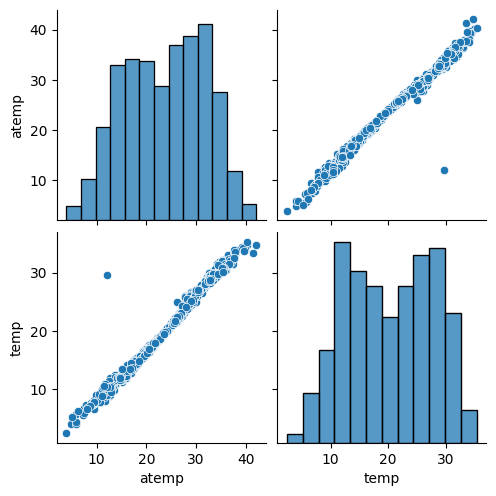

In [1274]:
#Analysing temp vs atemp 
sns.pairplot(day,vars=['atemp','temp'])

In [1275]:
#From the data dictonary we know that atemp and temp are mostly the same data. From the graph we can infer they are linerally dependent and hence have only one column. we can drop temp and consider atemp
day.drop(['temp'],axis=1,inplace=True)

<Figure size 1600x1000 with 0 Axes>

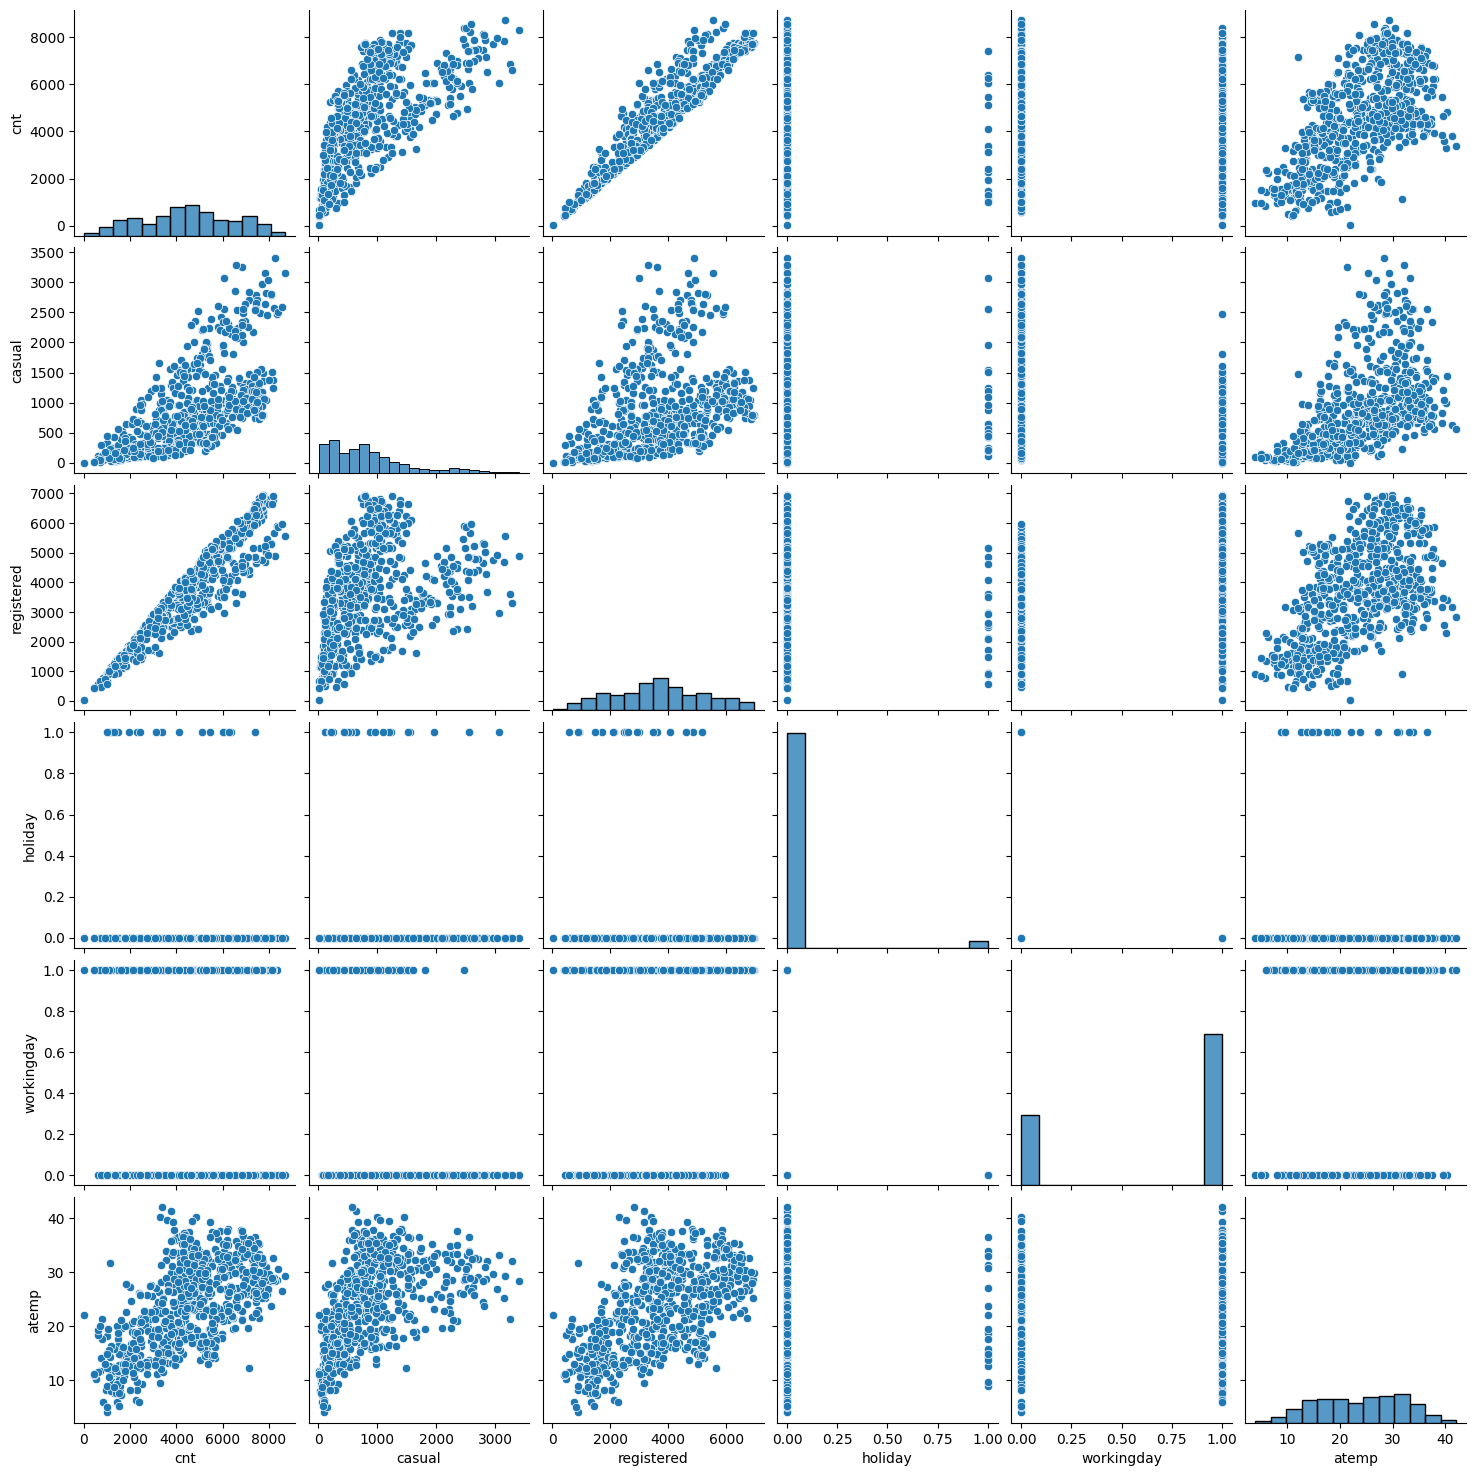

In [1276]:
#Let us explore the causal and registered data with others
plt.figure(figsize = (16, 10))
sns.pairplot(day,vars=['cnt','casual','registered','holiday','workingday','atemp'])
plt.show()

In [1277]:
#Registered is more in case of workingday and causal is more in case of holiday.There may be more inference from the analysis but since the target variable is "cnt" which can be derived from a sum of casual and registered we can drop the column.
day.drop(['casual','registered'],axis=1,inplace=True)


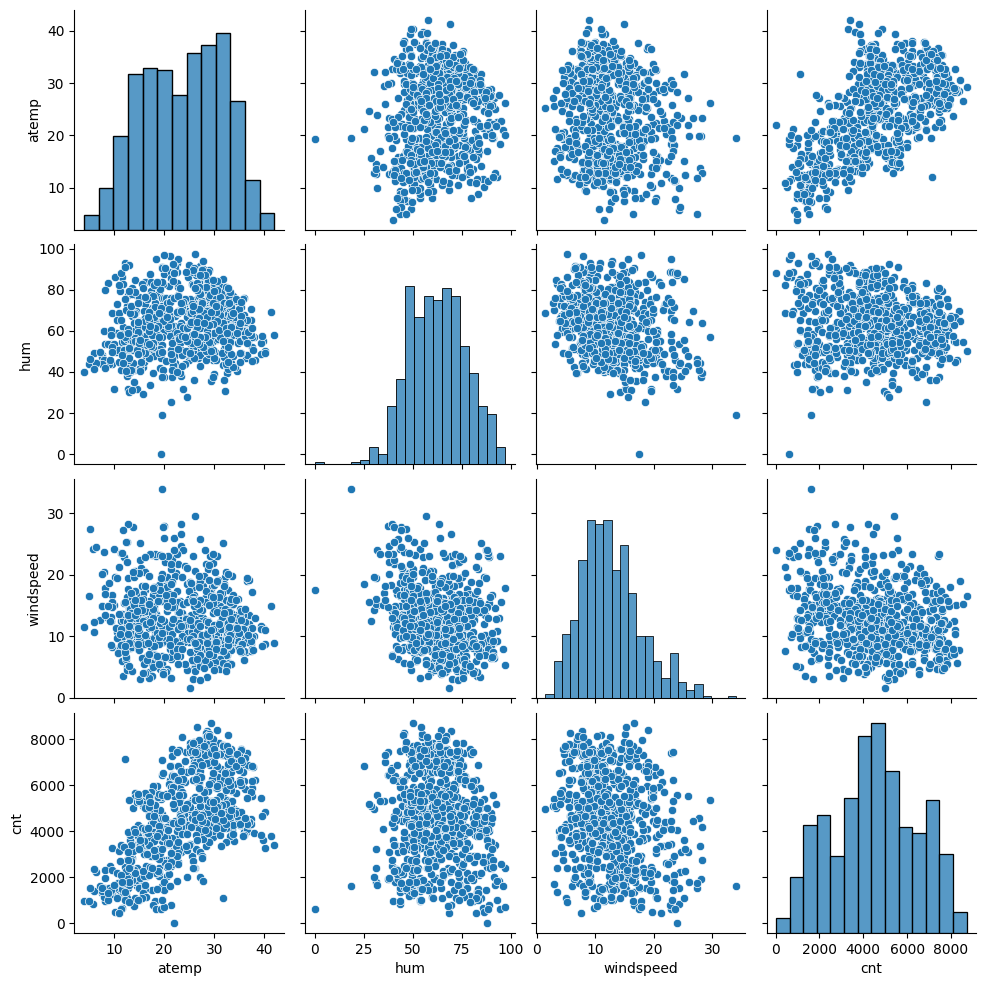

In [1278]:
#Numerical plot analysis
sns.pairplot(day, vars=['atemp','hum','windspeed',"cnt"])
plt.show()

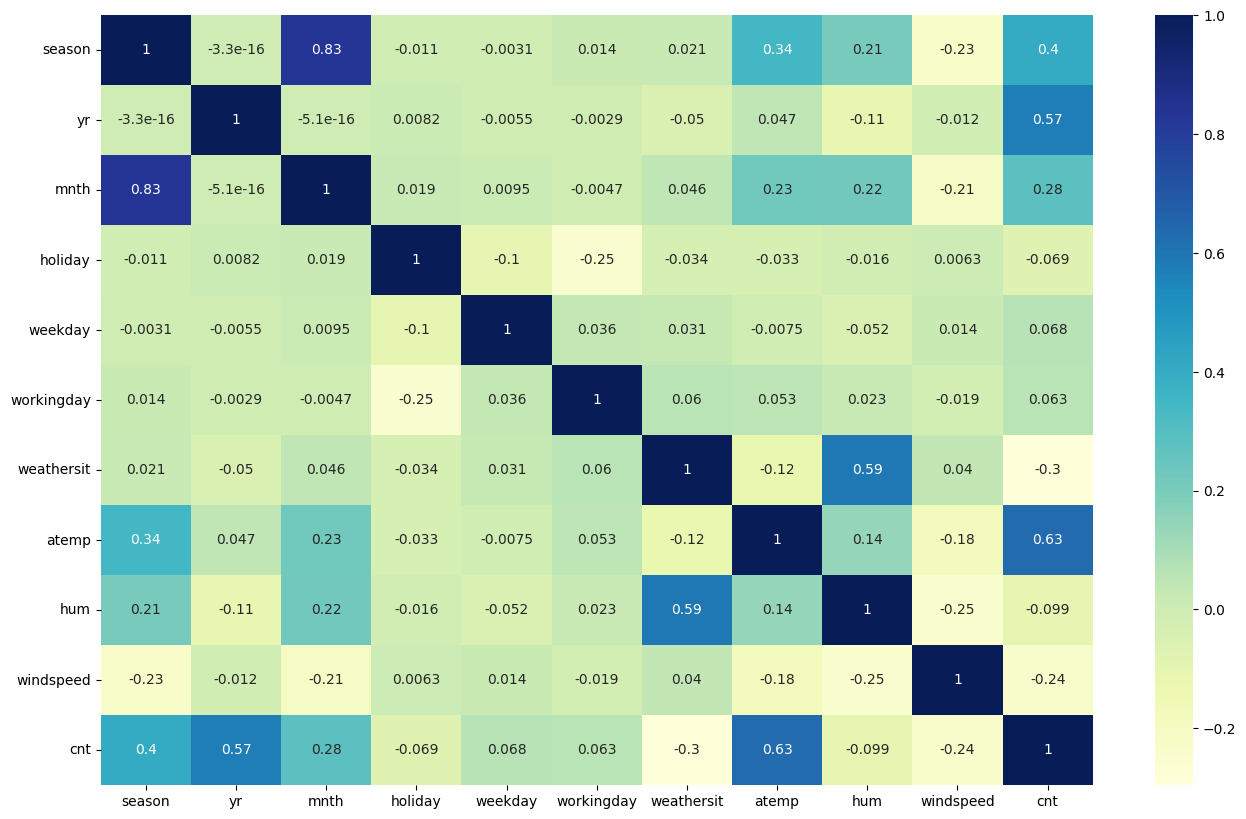

In [1279]:
#Correlation matrix
plt.figure(figsize = (16, 10))
sns.heatmap(day.corr(), annot = True, cmap="YlGnBu")
plt.show()

From the corr 
1. count has a high correlation with atemp
2. Weather sit and humididty have a good positive correlation.
3. Weathersit and mnth , atemp and season have a resonble correlation
4. cnt is negatively correlated with windspeed.

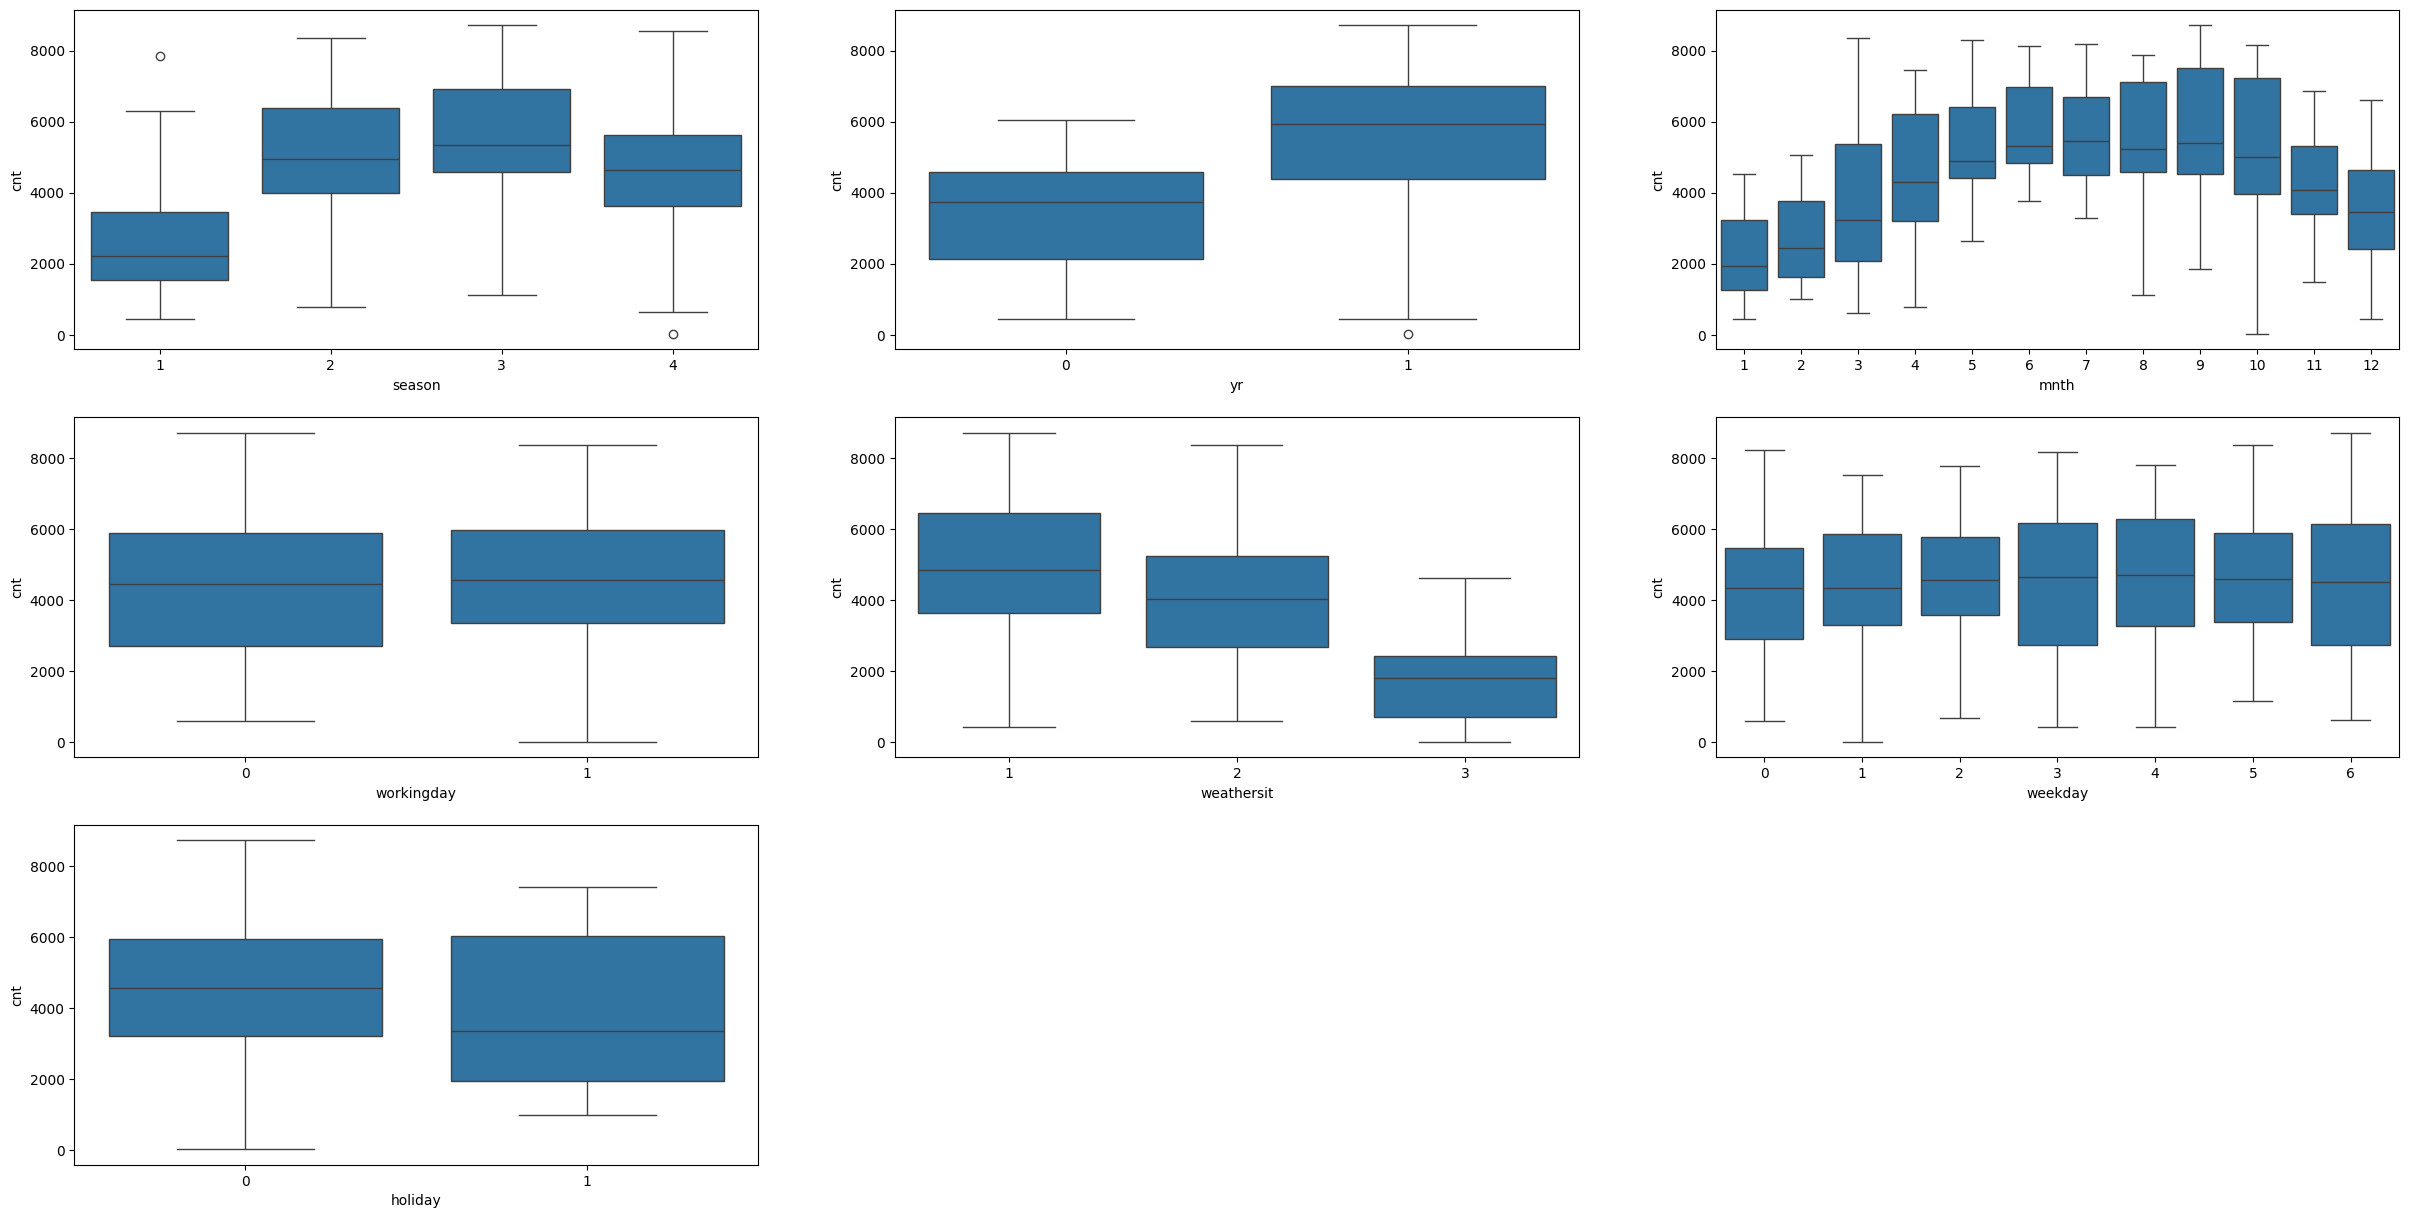

In [1280]:
#Visualising categorical Variables to understand data better
#yr','mnth','workingday','weathersit','weekday'
plt.figure(figsize=(30, 15))
plt.subplot(3,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = day)
plt.subplot(3,3,2)
sns.boxplot(x = 'yr', y = 'cnt', data = day)
plt.subplot(3,3,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = day)
plt.subplot(3,3,4)
sns.boxplot(x = 'workingday', y = 'cnt', data = day)
plt.subplot(3,3,5)
sns.boxplot(x = 'weathersit', y = 'cnt', data = day)
plt.subplot(3,3,6)
sns.boxplot(x = 'weekday', y = 'cnt', data = day)
plt.subplot(3,3,7)
sns.boxplot(x = 'holiday', y = 'cnt', data = day)
plt.show()

- Count is higher in holidays 
- Count is more in clear or misty weather . it decreases in snow but null in case of heavy rains 
- 0 , 3 , 6 of weeday have mostly highest count 
- 10 show higher increase in count but mostly in 3 , 9 , 10
- 2019 has higher count.
- summer and fall have higher count.
- working day dosen't seem to have a high difference


Dummy Variables

In [1281]:
#Creating dummy variables for categorical data
#dropping the first column since we need n-1 columns to describe the data
dummy_fields = ['season', 'weathersit', 'mnth', 'weekday']
for dm in dummy_fields:
    dummies = pd.get_dummies(day[dm],prefix='', prefix_sep='' , drop_first=True,dtype=int)
    day = pd.concat([day,dummies],axis=1)

In [1282]:
# Dropping actual fields of dummy variables 
day.pop('weekday')
day.pop('weathersit')
day.pop('mnth')
day.pop('season')

0      1
1      1
2      1
3      1
4      1
      ..
725    1
726    1
727    1
728    1
729    1
Name: season, Length: 730, dtype: int64

In [1283]:

day.shape

(730, 29)

In [1284]:
# split into train and test data
df_train , df_test = train_test_split(day,test_size=0.34, random_state=70, shuffle=True)


Scaling - Min/Max scaling

In [1285]:
# atemp , hum , windspeed are on different scales and scaling them to a normalised scale of 0 to 1 can help in better modelling.
# Using Min Max scaler for scaling the data.
scaler = MinMaxScaler()
num_vars = ['atemp','hum','windspeed']
df_train[num_vars]=scaler.fit_transform(df_train[num_vars])
df_train.head()


,yr,holiday,workingday,atemp,hum,windspeed,cnt,season_2,season_3,season_4,...,mnth_9,mnth_10,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
120,0,0,0,0.508559,0.783633,0.173093,3351,1,0,0,...,0,0,0,0,0,0,0,0,0,0
439,1,0,1,0.492061,0.865895,0.187190,4378,0,0,0,...,0,0,0,0,0,0,0,0,1,0
392,1,0,0,0.340720,0.558697,0.388473,4023,0,0,0,...,0,0,0,0,0,0,0,0,0,1
241,0,0,1,0.710393,0.563839,0.211549,5204,0,1,0,...,0,0,0,0,0,1,0,0,0,0
633,1,0,1,0.713023,0.648671,0.457682,7733,0,0,1,...,1,0,0,0,0,0,1,0,0,0


In [1286]:
#checking if all mins and max are in the range 0 and 1 
df_train.describe()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,season_2,season_3,season_4,...,mnth_9,mnth_10,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
count,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,...,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000
mean,0.498960,0.033264,0.681913,0.536632,0.643024,0.342944,4449.681913,0.247401,0.257796,0.234927,...,0.083160,0.074844,0.074844,0.101871,0.143451,0.126819,0.153846,0.155925,0.135135,0.143451
std,0.500519,0.179512,0.466218,0.222114,0.149312,0.162050,1989.963923,0.431951,0.437877,0.424395,...,0.276412,0.263414,0.263414,0.302794,0.350897,0.333117,0.361177,0.363162,0.342224,0.350897
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.340726,0.533848,0.224357,3068.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.539897,0.632820,0.324359,4484.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.728654,0.748072,0.434609,5918.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8714.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1287]:
#Before we train lets get the target variable and dependent variable
y_train = df_train.pop('cnt')
X_train = df_train

Simple Linear Regression

In [1288]:
# Utility Function to build model using Stats model
def build_model(cols):
    X_train_sm = sm.add_constant(X_train[cols])
    lm = sm.OLS(y_train, X_train_sm).fit()
    print(lm.summary())
    return lm

In [1289]:
#Building with only oen variable with highest corr , 'atemp'
build_model(['atemp'])

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     374.6
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           4.39e-62
Time:                        21:26:10   Log-Likelihood:                -4196.7
No. Observations:                 481   AIC:                             8397.
Df Residuals:                     479   BIC:                             8406.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1264.6889    178.068      7.102      0.0

In [1290]:
#Adding a new column yr to check its impact.
build_model(['atemp','yr'])


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     540.8
Date:                Mon, 05 Aug 2024   Prob (F-statistic):          1.77e-123
Time:                        21:26:10   Log-Likelihood:                -4051.2
No. Observations:                 481   AIC:                             8108.
Df Residuals:                     478   BIC:                             8121.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        480.0609    137.492      3.492      0.0

In [1291]:
#Adding a new column hum to check its impact.
build_model(['atemp','yr','hum'])

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     398.6
Date:                Mon, 05 Aug 2024   Prob (F-statistic):          1.57e-129
Time:                        21:26:10   Log-Likelihood:                -4033.8
No. Observations:                 481   AIC:                             8076.
Df Residuals:                     477   BIC:                             8092.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1689.2116    242.001      6.980      0.0

- There is a increase in the R2 squared value as we add new values .With hum we notice there is a good 70.1% variance explanation.
-  There is no change in P value it remains low. 
- The prob of F-statistics is also los

Building with All variables - Model 1 

In [1292]:
#Using all columns of X_train 
build_model(X_train.columns)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     97.03
Date:                Mon, 05 Aug 2024   Prob (F-statistic):          1.52e-169
Time:                        21:26:10   Log-Likelihood:                -3875.2
No. Observations:                 481   AIC:                             7806.
Df Residuals:                     453   BIC:                             7923.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1590.1663    282.578      5.627   

- 85% variance which is a good model
- P value of a lot of variables are high.


In [1293]:
# Utility to calculate VIF
# Takes the columns for which VIF to be calculated as a parameter
def get_vif(cols):
    df1 = X_train[cols]
    vif = pd.DataFrame()
    vif['Features'] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    print(vif.sort_values(by='VIF',ascending=False))

VIF for Model 1 

In [1294]:
get_vif(X_train.columns)

        Features    VIF
23     weekday_2    inf
2     workingday    inf
22     weekday_1    inf
26     weekday_5    inf
25     weekday_4    inf
24     weekday_3    inf
1        holiday    inf
3          atemp  39.42
4            hum  20.51
7       season_3  12.97
6       season_2   8.87
17        mnth_8   8.56
16        mnth_7   8.05
8       season_4   7.81
15        mnth_6   7.41
18        mnth_9   6.13
14        mnth_5   6.00
13        mnth_4   5.62
5      windspeed   5.32
19       mnth_10   4.83
20       mnth_11   4.44
21       mnth_12   3.38
12        mnth_3   2.81
9   weathersit_2   2.17
0             yr   2.03
27     weekday_6   1.92
11        mnth_2   1.84
10  weathersit_3   1.33


A lot of values have high VF.
We can proceed by dropping high p-value and high VIF and remodel.
Before that performing a Automatic feature selection using RFE .

RFE Feature selection

In [1295]:
#Fitting using sklearn
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [1296]:
#Cut down number of features to 20 using automated approach
rfe = RFE(estimator=lr, n_features_to_select=20)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=20)

In [1297]:
#Columns selected by RFE and their weights
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_2', True, 1),
 ('season_3', True, 1),
 ('season_4', True, 1),
 ('weathersit_2', True, 1),
 ('weathersit_3', True, 1),
 ('mnth_2', False, 9),
 ('mnth_3', False, 5),
 ('mnth_4', False, 7),
 ('mnth_5', False, 3),
 ('mnth_6', False, 6),
 ('mnth_7', False, 8),
 ('mnth_8', True, 1),
 ('mnth_9', True, 1),
 ('mnth_10', False, 4),
 ('mnth_11', True, 1),
 ('mnth_12', True, 1),
 ('weekday_1', True, 1),
 ('weekday_2', True, 1),
 ('weekday_3', True, 1),
 ('weekday_4', True, 1),
 ('weekday_5', True, 1),
 ('weekday_6', False, 2)]

In [1298]:
#Print Columns selected by RFE. We will manually eliminate for these columns
X_train.columns[rfe.support_]

Index(['yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'season_2',
       'season_3', 'season_4', 'weathersit_2', 'weathersit_3', 'mnth_8',
       'mnth_9', 'mnth_11', 'mnth_12', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5'],
      dtype='object')

In [1299]:
# Taking 20 columns supported by RFE for regression
X_train_rfe = X_train[['yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'season_2',
       'season_3', 'season_4', 'weathersit_2', 'weathersit_3', 'mnth_8',
       'mnth_9', 'mnth_10', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6']]

In [1300]:
X_train_rfe.shape

(481, 20)

Building Model 2 


['yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'season_2',
       'season_3', 'season_4', 'weathersit_2', 'weathersit_3', 'mnth_8',
       'mnth_9', 'mnth_10', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6']

In [1301]:
cols2 = ['yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'season_2',
       'season_3', 'season_4', 'weathersit_2', 'weathersit_3', 'mnth_8',
       'mnth_9', 'mnth_10', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6']

In [1302]:
# building for model 2
build_model(cols2)
#VIF for model 2
get_vif(cols2)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     136.0
Date:                Mon, 05 Aug 2024   Prob (F-statistic):          3.25e-175
Time:                        21:26:11   Log-Likelihood:                -3881.6
No. Observations:                 481   AIC:                             7803.
Df Residuals:                     461   BIC:                             7887.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1621.8863    265.328      6.113   

In [1303]:
#Though the R2 score is high , we also have High p-value and high VIF value.
#Series of model building by dropping each variable.

In [1304]:
#dropping weekday 3 , P-value = .986
cols = ['yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'season_2',
       'season_3', 'season_4', 'weathersit_2', 'weathersit_3', 'mnth_8',
       'mnth_9', 'mnth_10', 'weekday_1', 'weekday_2', 'weekday_4',
       'weekday_5', 'weekday_6']
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     136.0
Date:                Mon, 05 Aug 2024   Prob (F-statistic):          3.25e-175
Time:                        21:26:11   Log-Likelihood:                -3881.6
No. Observations:                 481   AIC:                             7803.
Df Residuals:                     461   BIC:                             7887.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1621.8863    265.328      6.113   

In [1305]:
#dropping weekday 4 , P-value = .862
cols = ['yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'season_2',
       'season_3', 'season_4', 'weathersit_2', 'weathersit_3', 'mnth_8',
       'mnth_9', 'mnth_10', 'weekday_1', 'weekday_2', 
       'weekday_5', 'weekday_6']
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     143.7
Date:                Mon, 05 Aug 2024   Prob (F-statistic):          3.23e-176
Time:                        21:26:11   Log-Likelihood:                -3881.8
No. Observations:                 481   AIC:                             7802.
Df Residuals:                     462   BIC:                             7881.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1629.0448    264.900      6.150   

In [1306]:
#dropping weekday 2,5,1.
cols = ['yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'season_2',
       'season_3', 'season_4', 'weathersit_2', 'weathersit_3', 'mnth_8',
       'mnth_9', 'mnth_10', 'weekday_6']
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     170.4
Date:                Mon, 05 Aug 2024   Prob (F-statistic):          5.49e-178
Time:                        21:26:11   Log-Likelihood:                -3885.6
No. Observations:                 481   AIC:                             7803.
Df Residuals:                     465   BIC:                             7870.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1701.2794    264.686      6.428   

In [1307]:
#dropping  mnth 8  
cols = ['yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'season_2',
       'season_3', 'season_4', 'weathersit_2', 'weathersit_3',
       'mnth_9', 'mnth_10', 'weekday_6']
build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     179.3
Date:                Mon, 05 Aug 2024   Prob (F-statistic):          2.09e-177
Time:                        21:26:11   Log-Likelihood:                -3889.7
No. Observations:                 481   AIC:                             7809.
Df Residuals:                     466   BIC:                             7872.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1648.5162    266.007      6.197   

In [1308]:
#After continuous eliminating and analysis using High VIF , corr , p-value dropping workingDay
#hum - high VIF value
#season_3 - removal is decreasing VIF of atemp which is highly correlated to cnt.
#Based on error analysis dropped holiday , mnth10

In [1309]:
cols3=['yr', 'atemp', 'windspeed', 'season_2',
        'season_4', 'weathersit_2', 'weathersit_3',
       'mnth_9','weekday_6']
build_model(cols3)
get_vif(cols3)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     235.2
Date:                Mon, 05 Aug 2024   Prob (F-statistic):          5.03e-168
Time:                        21:26:11   Log-Likelihood:                -3925.9
No. Observations:                 481   AIC:                             7872.
Df Residuals:                     471   BIC:                             7914.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          811.3354    165.222      4.911   


       Features   VIF
1         atemp  3.97
2     windspeed  3.54
0            yr  1.96
3      season_2  1.59
5  weathersit_2  1.42
4      season_4  1.34
7        mnth_9  1.19
8     weekday_6  1.18
6  weathersit_3  1.11


Residual Analysis


In [1310]:
#Build a model sklearn utility
def build_model_sk(X,y):
    lr1 = LinearRegression()
    lr1.fit(X,y)
    return lr1

In [1311]:
#Let us build the final model using sklearn
#Build a model with cols3 columns
lr = build_model_sk(X_train[cols3],y_train)
print(lr.intercept_,lr.coef_)

811.33538186021 [ 1956.14340693  5087.31106064  -790.68979049   735.03572841
  1046.81136641  -686.5506875  -2369.49378039   800.81418969
    98.06834211]


Prediction of train data 

In [1312]:
y_train_pred = lr.predict(X_train[cols3])

In [1313]:
#Plot a histogram of the error terms
def plot_res_dist(act, pred):
    # Calculate residuals
    residuals = act - pred
    # Calculate the mean of residuals
    mean_residual = residuals.mean()
    print("Mean residual" , mean_residual)
    # Create the distribution plot
    sns.distplot(residuals)
    plt.title('Error Terms')
    plt.xlabel('Errors')

Mean residual -4.3489351644027756e-14


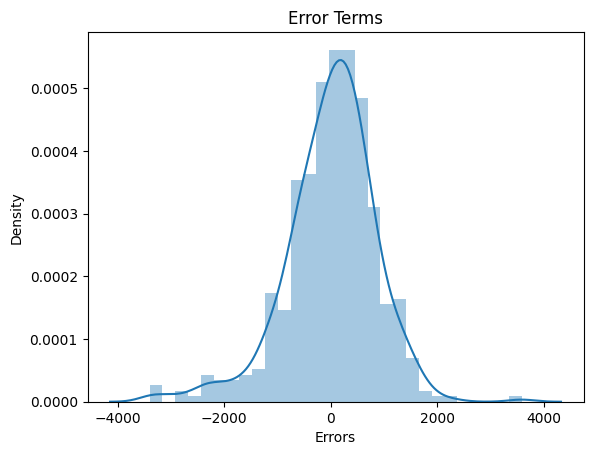

In [1314]:
plot_res_dist(y_train, y_train_pred)

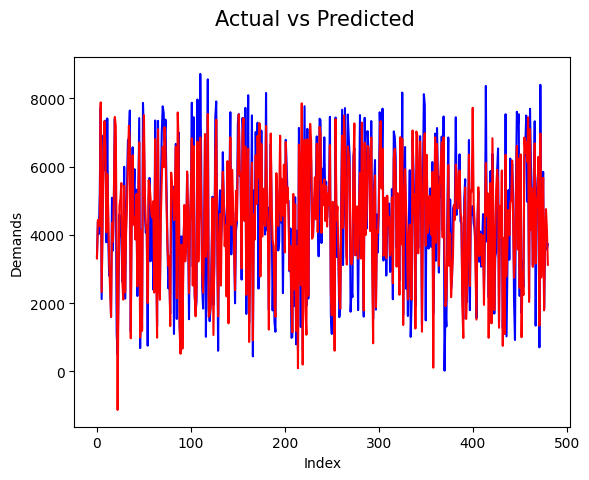

In [1315]:
# Actual vs Predicted
c = [i for i in range(0,len(X_train),1)]
plt.plot(c,y_train, color="blue")
plt.plot(c,y_train_pred, color="red")
plt.suptitle('Actual vs Predicted', fontsize = 15)
plt.xlabel('Index')
plt.ylabel('Demands')
plt.show()

In [1316]:
#Print R-squared Value
r2_score(y_train,y_train_pred)

0.8179861016233692

Prediction on Test data analysis

In [1317]:
#Scale variables in X_test
num_vars = ['atemp','hum','windspeed']

#Test data to be transformed only, no fitting
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [1318]:
y_test = df_test.pop("cnt")
X_test = df_test

In [1319]:
df_test.head()

,yr,holiday,workingday,atemp,hum,windspeed,season_2,season_3,season_4,weathersit_2,...,mnth_9,mnth_10,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
625,1,0,1,0.669562,0.897172,0.691023,0,1,0,1,...,1,0,0,0,0,1,0,0,0,0
572,1,0,1,0.902602,0.611396,0.269239,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
201,0,0,1,1.029563,0.710797,0.411546,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
148,0,0,0,0.739113,0.841902,0.394883,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
512,1,1,0,0.826942,0.695373,0.358977,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [1320]:
#Predicting test data values
y_test_pred = lr.predict(X_test[cols3])

In [1321]:
#evaluating the model based on r2_score(as mentioned in the problem statement as well)
y_pred=y_test_pred
r2_score(y_test, y_pred)

0.7934564688726337

Mean residual 0.044487767755594446


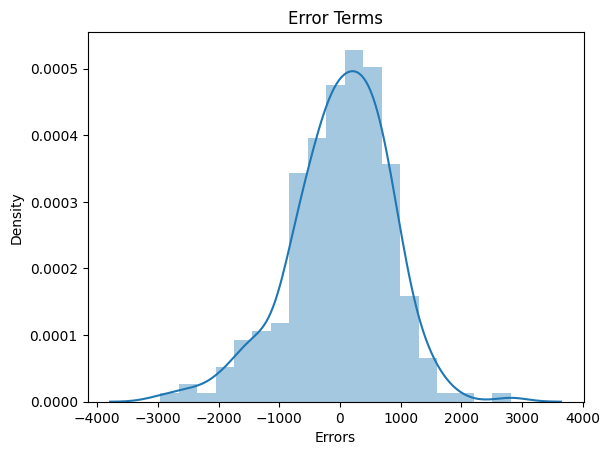

In [1322]:
plot_res_dist(y_test, y_test_pred)

Text(0, 0.5, 'y_pred')

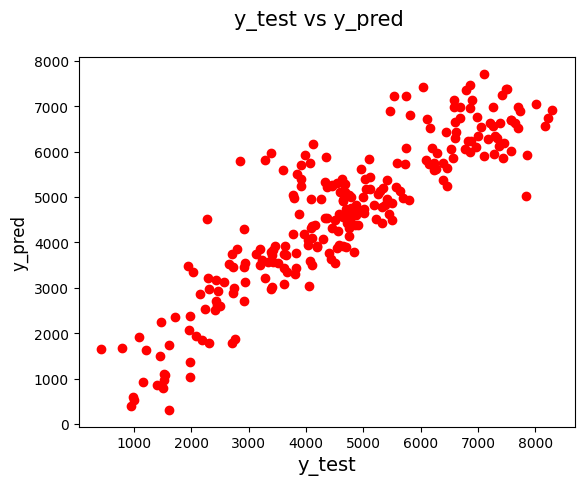

In [1325]:
fig = plt.figure()
plt.scatter(y_test, y_pred , color='red')
fig.suptitle('y_test vs y_pred', fontsize = 15)             
plt.xlabel('y_test', fontsize = 14 )                          
plt.ylabel('y_pred', fontsize = 12) 

Conclusion : 

Prominent Features chosen are year
cols3=['yr', 'atemp', 'windspeed', 'season_2',
        'season_4', 'weathersit_2', 'weathersit_3',
       'mnth_9','weekday_6']
- month september 
-'yr',
 'holiday',
 'atemp',
 'windspeed',
 'season_2',
 'season_4',
 'weathersit_3',
 '

1. From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?
Season: Bike rentals are typically higher during warmer seasons (spring and summer).
Year: There might be an increasing trend in bike rentals over the years due to growing awareness of eco-friendly transportation.
Month: Bike rentals are usually higher during spring and summer months.
Holiday: Bike rentals tend to be lower on holidays.
Weekday: Weekends might have higher rentals compared to weekdays, but it's essential to consider local culture and work patterns.
Workingday: Working days might have higher rentals, but this can vary based on the city and its demographics.
Weather: Clear weather conditions generally lead to higher bike rentals.
2. Why is it important to use drop_first=True during dummy variable creation?
Using drop_first=True in dummy variable creation prevents multicollinearity. It avoids the dummy variable trap by excluding one category from the dummy variables. This is because the information from the excluded category can be inferred from the presence or absence of the other categories.

3. Looking at the pair-plot among the numerical variables, which one has the highest correlation with the target variable?
Temperature (or atemp) typically shows the highest correlation with the target variable (bike rentals). Warmer temperatures are often associated with increased bike usage.   

4. How did you validate the assumptions of Linear Regression after building the model on the training set?
To validate the assumptions of linear regression, we can use the following methods:

Residual plots: Check for normality, heteroscedasticity, and autocorrelation.
Normality test: Use statistical tests like the Shapiro-Wilk test to check for normality of residuals.
Multicollinearity: Calculate VIF (Variance Inflation Factor) to check for multicollinearity among independent variables.
Influential points: Identify outliers or influential points that might affect the model.
5. Based on the final model, which are the top 3 features contributing significantly towards explaining the demand of the shared bikes?
The top 3 features contributing to bike demand typically include:   

Temperature (or atemp)
Season
Hour (if available) or Weekday
Note: The specific features might vary based on the dataset and model.

General Subjective Questions
1. Explain the linear regression algorithm in detail.
Linear regression is a statistical method used to model the relationship between a dependent variable and one or more independent variables. It assumes a linear relationship between the variables. The goal is to find the best-fitting line (or hyperplane in case of multiple independent variables) that minimizes the sum of squared residuals.   

2. Explain the Anscombe's quartet in detail.
Anscombe's quartet is a set of four datasets that have almost identical statistical properties (mean, variance, correlation, etc.) but look very different when plotted. It demonstrates the importance of visualizing data before applying statistical methods. It highlights the limitations of relying solely on summary statistics.

3. What is Pearson's R?
Pearson's correlation coefficient (R) is a statistical measure that quantifies the linear relationship between two continuous variables. It ranges from -1 to 1, where:

1 indicates a perfect positive correlation
-1 indicates a perfect negative correlation   
0 indicates no correlation   
4. What is scaling? Why is scaling performed? What is the difference between normalized scaling and standardized scaling?
Scaling is the process of transforming data to a common scale. It is performed to improve the performance of machine learning algorithms, especially those sensitive to feature scales.   

Normalized scaling: Rescales features to a specific range, typically 0 to 1.
Standardized scaling: Rescales features to have zero mean and unit variance.
5. You might have observed that sometimes the value of VIF is infinite. Why does this happen?
A VIF value of infinity indicates perfect multicollinearity between independent variables. This means one variable is a perfect linear combination of other variables, leading to singularity in the design matrix and making it impossible to estimate the model parameters.